In [1]:
# Uncomment line below if working in a CoLab environment
#!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)

2.1.0


#### $ \S \text{ Preprocessing}$

#### BBC Data Pipeline

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import csv
import os

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-03-21 02:21:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2020-03-21 02:21:32 (216 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [0]:

os.chdir("/tmp")
data = []
labels = []


with open("bbc-text.csv", 'r') as f:
  reader = csv.reader(f)
  next(reader)
  
  for row in reader:
    data.append(row[1])
    labels.append(row[0])

# Embedding parameters
vocab_size = 2000
embedding_dim = 16
max_length = 1000
trunc_type = "post"
oov_token = "<OOV>"


# Percentage of data to use for validation
partition_size = 0.8
split = int(len(data)*partition_size)
train_data = data[split:]
test_data = data[:split]


# Fit tokenizer to training data, and sequnce
data_tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
label_tokenizer = Tokenizer(num_words = len(set(labels)))
data_tokenizer.fit_on_texts(train_data)
label_tokenizer.fit_on_texts(labels)

# Load and reverse word index
word_index = data_tokenizer.word_index
label_index = label_tokenizer.word_index
reverse_index = {val:key for key,val in word_index.items()}

# Tokenize and encode 
train_seq = data_tokenizer.texts_to_sequences(train_data) 
test_seq = data_tokenizer.texts_to_sequences(test_data)
label_seq = [label_index[label] for label in labels]

# Pad sequences 
train_pad = pad_sequences(train_seq, maxlen=max_length, truncating=trunc_type)
test_pad = pad_sequences(test_seq, maxlen=max_length, truncating=trunc_type)

# Fully processed data
train_data = np.array(train_pad)
test_data = np.array(test_pad)

# Preprocess labels
train_labels = np.array(label_seq[split:])
test_labels = np.array(label_seq[:split])


In [4]:
tf.keras.backend.clear_session()

# Embedding parameters
vocab_size = 2000
embedding_dim = 16
max_length = 1000
trunc_type = "post"
oov_token = "<OOV>"

# Convolution Parameters
filters1 = 128
kernel_size1 = 5
strides1 = 1


model = tf.keras.Sequential([
                             
    tf.keras.layers.Embedding(input_dim = vocab_size, 
                              output_dim = embedding_dim, 
                              input_length = max_length),
                             
    tf.keras.layers.Conv1D(filters = filters1,
                         kernel_size = kernel_size1,
                         padding = "causal",
                         strides = strides1),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    tf.keras.layers.Dense(36, activation='relu'),
    
    tf.keras.layers.Dense(6, activation='sigmoid')

])


model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          32000     
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 128)         10368     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 36)                2340      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 222       
Total params: 86,146
Trainable params: 86,146
Non-trainable params: 0
_________________________________________________________________


In [5]:
epochs = 20
history = model.fit(train_data, 
                    train_labels, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=(test_data, test_labels))

Train on 445 samples, validate on 1780 samples
Epoch 1/20
445/445 [==============================] - 6s 13ms/sample - loss: 1.7688 - accuracy: 0.2157 - val_loss: 1.7139 - val_accuracy: 0.2270
Epoch 2/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.6488 - accuracy: 0.2382 - val_loss: 1.6114 - val_accuracy: 0.2270
Epoch 3/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.6028 - accuracy: 0.2382 - val_loss: 1.6084 - val_accuracy: 0.2270
Epoch 4/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.5997 - accuracy: 0.2382 - val_loss: 1.6067 - val_accuracy: 0.2270
Epoch 5/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.5981 - accuracy: 0.2382 - val_loss: 1.6093 - val_accuracy: 0.2270
Epoch 6/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.5938 - accuracy: 0.2539 - val_loss: 1.6028 - val_accuracy: 0.2522
Epoch 7/20
445/445 [==============================] - 2s 5ms/sample - loss: 1.5847 - acc

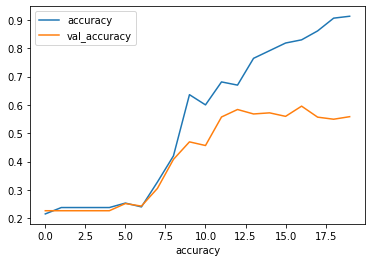

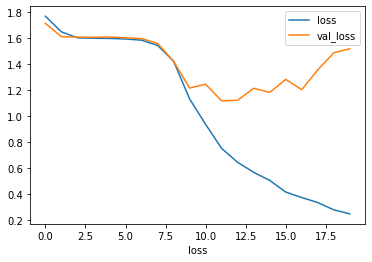

In [6]:
import matplotlib.pyplot as plt


def graph(hist, metric):
  plt.plot(hist.history[metric])
  plt.plot(hist.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.xlabel(metric)
  plt.legend([metric, "val_"+metric])
  plt.show()

graph(history, "accuracy")
graph(history, "loss")

In [11]:
# Examine a few data samples and their precitions

predictions = model.predict(np.array([test_data[-3], test_data[-4]]))

print("Label disctionary: ", label_index)
print("\nText: ",data[-3])
print("\nClass: ",labels[-3])
predicted_index = [i for i,arg in enumerate(predictions[0]) if arg==max(predictions[0])]
print("Predicted index : {}".format(predicted_index))
print("Correct index : {}".format(label_index[labels[-3]]))


print("\n\n\nText: ",data[-4])
print("\nClass: ",labels[-4])
predicted_index = [i for i,arg in enumerate(predictions[1]) if arg==max(predictions[1])]
print("Predicted index : {}".format(predicted_index))
print("Correct index : {}".format(label_index[labels[-4]]))

Label disctionary:  {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}

Text:  rem announce new glasgow concert us band rem have announced plans to perform for 10 000 scottish fans in a rescheduled gig.  the band will play in what has been dubbed europe s biggest tent on glasgow green on tuesday  14 june. they were forced to pull out of a concert at the secc in glasgow last month after bassist mike mills contracted flu. fans who bought tickets for the original 22 february show can attend the rescheduled concert. the june gig will act as a warm-up for rem s open air concert at balloch castle country park  on the banks of loch lomond  four days later.  promoters regular music booked glasgow green as the secc was not available on the most suitable date. mark mackie  director of regular music  said:  it is fantastic news and it really shows rem s commitment to their scottish fans that they are coming back to glasgow for what will be a truly unique gig.  the rem gigs 

In [0]:
# We can visualize the embeddings of our model by executing this code

import io
out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')

classification_layer = model.layers[0]
weights = classification_layer.get_weights()[-1]

'''

Examine the way this model organized words in a higher dimensional space
By taking the files produced above to 

https://projector.tensorflow.org/


'''


for word_num in range(1, vocab_size):
  word = reverse_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word+"\n")
  out_v.write(word+"\n".join([str(x) for x in embeddings]) + "\n")
out_m.close()
out_v.close()